Source:
- https://github.com/abhinavsagar/Breast-cancer-classification 

In [1]:
import json
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import tensorflow as tf
import gc
import itertools
import random

from PIL import Image
from functools import partial
from sklearn import metrics
from collections import Counter
from keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

from keras import layers
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam

In [12]:
BATCH_SIZE = 16
INPUT_SHAPE = 64
ORIGIN_SHAPE = False
EPOCHS = 3

In [13]:
def get_all_images(path, resize_param, origin_shape):

    images = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

    for folder in os.listdir(path):

        if "." not in folder: 

            for image in os.listdir(path + folder):

                img = cv2.imread(path + folder + "/" + image)
                # img = read(path + folder + "/" + image)

                if origin_shape:

                    dim = (700, 460)
                    img = cv2.resize(img, dim)

                else:

                    img = cv2.resize(img, (resize_param, resize_param))

                images.append(np.array(img))

    return images

In [14]:
benign_path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/benign/'
malignant_path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_40X/malignant/'

# benign_path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_100X/benign/'
# malignant_path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_100X/malignant/'

# benign_path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_200X/benign/'
# malignant_path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_200X/malignant/'

# benign_path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_400X/benign/'
# malignant_path = 'D:/Medical_Imaging_Zusatz/BreaKHis_v1/Dataset_400X/malignant/'

In [15]:
benign_images = np.array(get_all_images(benign_path, INPUT_SHAPE, ORIGIN_SHAPE))
malignant_images = np.array(get_all_images(malignant_path, INPUT_SHAPE, ORIGIN_SHAPE))

print(len(benign_images))
print(len(malignant_images))

625
1370


In [16]:
print(benign_images.shape)
print(malignant_images.shape)

(625, 64, 64, 3)
(1370, 64, 64, 3)


In [17]:
random.Random(4).shuffle(benign_images)
random.Random(4).shuffle(malignant_images)

In [18]:
split = 0.8

benign_train = benign_images[ : int(len(benign_images) * split)]
benign_test = benign_images[int(len(benign_images) * split) : ]
malignant_train = malignant_images[ : int(len(malignant_images) * split)]
malignant_test = malignant_images[int(len(malignant_images) * split) : ]

print("benign_train length: ", len(benign_train))
print("benign_test length: ", len(benign_test))
print("malignant_train length: ", len(malignant_train))
print("malignant_test length: ", len(malignant_test))

benign_train length:  500
benign_test length:  125
malignant_train length:  1096
malignant_test length:  274


## Create Label

In [19]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malignant_train_label = np.ones(len(malignant_train))
benign_test_label = np.zeros(len(benign_test))
malignant_test_label = np.ones(len(malignant_test))

# Merge data 
X_train = np.concatenate((benign_train, malignant_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malignant_train_label), axis = 0)
X_test = np.concatenate((benign_test, malignant_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malignant_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

## Train and Evaluation Split

In [20]:
x_train, x_val, y_train, y_val = train_test_split(
                                                    X_train, Y_train, 
                                                    test_size = 0.2, 
                                                    random_state = 11
                                                )

## Display some Images

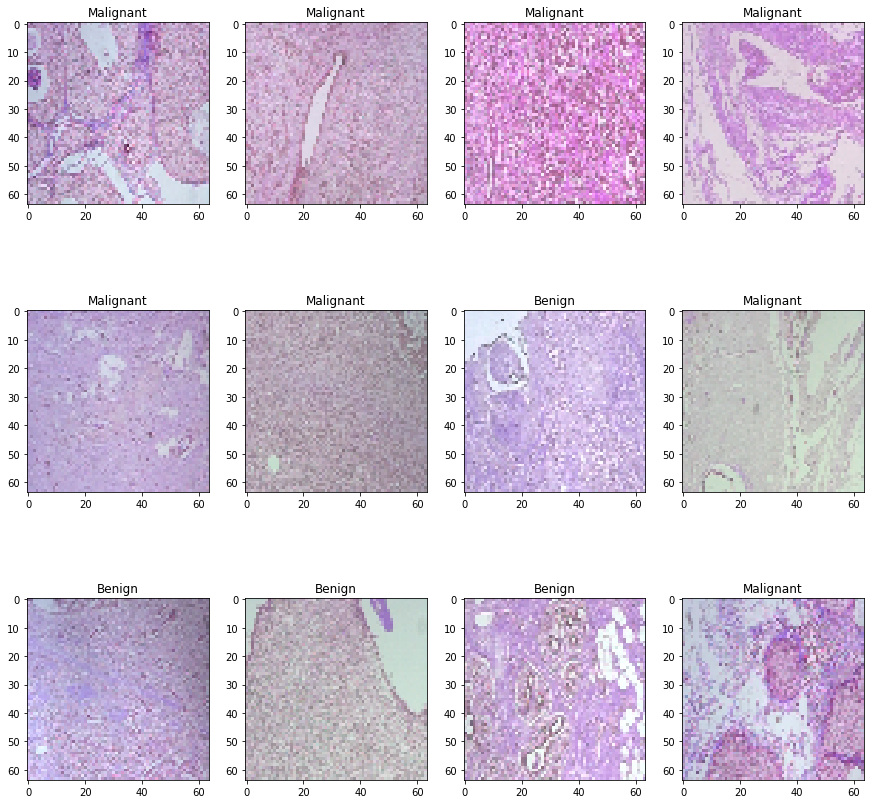

In [21]:
# # Display first 15 images of moles, and how they are classified
w = 60
h = 40
fig = plt.figure(figsize = (15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    
    ax = fig.add_subplot(rows, columns, i)
    
    if np.argmax(Y_train[i]) == 0:
    
        ax.title.set_text('Benign')
    
    else:
    
        ax.title.set_text('Malignant')
    
    plt.imshow(x_train[i], interpolation='nearest')

plt.show()

## Data Generator

In [22]:
# Using original generator
train_generator = ImageDataGenerator(
                                        zoom_range = 2,  # set range for random zoom
                                        rotation_range = 90,
                                        horizontal_flip = True,  # randomly flip images
                                        vertical_flip = True,  # randomly flip images
                                    )

## Model (DenseNet201)

In [23]:
def build_model(backbone, lr = 1e-4):

    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation = 'softmax'))
    
    
    model.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate = lr),
        metrics = ['accuracy']
    )
    
    return model

In [24]:
K.clear_session()
gc.collect()

if ORIGIN_SHAPE:

    shape = (460, 700, 3)

else:

    shape = (INPUT_SHAPE, INPUT_SHAPE, 3)

resnet = DenseNet201(
                        weights = 'imagenet',
                        include_top = False,
                        input_shape = shape
                    )

model = build_model(resnet , lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 2, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 3842      
                                                                 
Total params: 18,333,506
Trainable params: 18,100,610
No

In [14]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor = 'val_accuracy', patience = 5,
                                  verbose = 1, factor = 0.2, min_lr = 1e-7)

# Checkpoint
filepath = "./weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')

## Training and Evaluation

In [15]:
history = model.fit(
                        train_generator.flow(x_train, y_train, batch_size = BATCH_SIZE),
                        steps_per_epoch = x_train.shape[0] // BATCH_SIZE,
                        epochs = EPOCHS,
                        validation_data = (x_val, y_val),
                        callbacks = [learn_control] #, checkpoint
                    )

Epoch 1/3
80/80 [==============================] - 743s 9s/step - loss: 0.4862 - accuracy: 0.7917 - val_loss: 0.6109 - val_accuracy: 0.7329 - lr: 1.0000e-04
Epoch 2/3
80/80 [==============================] - 709s 9s/step - loss: 0.3229 - accuracy: 0.8892 - val_loss: 0.2835 - val_accuracy: 0.8602 - lr: 1.0000e-04
Epoch 3/3
80/80 [==============================] - 719s 9s/step - loss: 0.2544 - accuracy: 0.9072 - val_loss: 0.1692 - val_accuracy: 0.9286 - lr: 1.0000e-04


In [16]:
with open('./Histories/Dataset_200X/history_200X_256.json', 'w') as f:
    
    json.dump(str(history.history), f)

<AxesSubplot:>

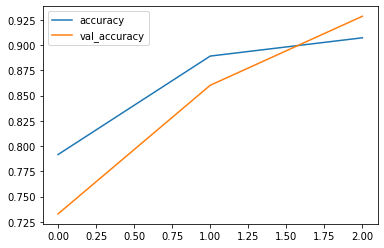

In [17]:
history_df = pd.DataFrame(history.history)
history_df[['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

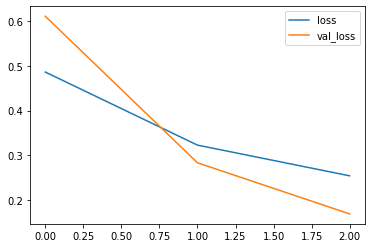

In [18]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

## Prediction

In [19]:
model.load_weights("D:/Medical_Imaging_Zusatz/Densenet_Weights/saved_weights/new_weights_densenet_40x_64.hdf5")

In [20]:
Y_val_pred = model.predict(x_val)

11/11 [==============================] - 35s 3s/step


In [21]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9285714285714286

In [22]:
Y_pred = model.predict(X_test)

13/13 [==============================] - 36s 3s/step


In [23]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\elias\AppData\Local\Temp/ipykernel_43728/3759147104.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
100%|██████████| 10/10 [06:56<00:00, 41.67s/it]


## Confusion Matrix

In [24]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 44  81]
 [ 68 210]]


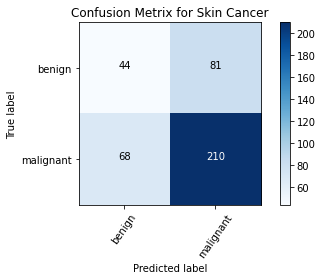

In [25]:
cm = confusion_matrix(np.argmax(Y_test, axis = 1), np.argmax(Y_pred, axis = 1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[ 26  99]
 [ 20 258]]


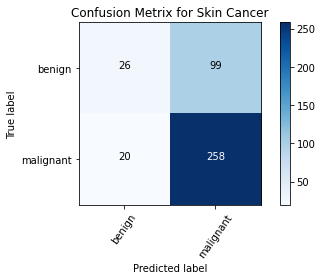

In [26]:
cm = confusion_matrix(np.argmax(Y_test, axis = 1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label = ['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

## Classification Report

In [27]:
from sklearn.metrics import classification_report

report = classification_report(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

print(report)

              precision    recall  f1-score   support

           0       0.57      0.21      0.30       125
           1       0.72      0.93      0.81       278

    accuracy                           0.70       403
   macro avg       0.64      0.57      0.56       403
weighted avg       0.67      0.70      0.65       403



In [28]:
report_path = "./Histories/Dataset_200X/report_200X_256.txt"

text_file = open(report_path, "w")
n = text_file.write(report)
text_file.close()

## ROC and AUC

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

In [ ]:
i = 0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):

    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):

        prop_class.append(i)

    if(len(prop_class)==8):

        break

i = 0

for i in range(len(Y_test)):

    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):

        mis_class.append(i)

    if(len(mis_class)==8):

        break

# # Display first 8 images of benign
w = 60
h = 40
fig = plt.figure(figsize = (18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    
    if namecode==0:
    
        return "Benign"
    
    else:
    
        return "Malignant"
    
for i in range(len(prop_class)):
    
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
    
plt.show()